## **Week 4: From MLPs to Convolutional Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

#### <ins>Understanding Layer Manipulation</ins>
1. Check existing architectures
2. Set a new model from an existing architecture
3. Apply model to a small dataset

#### <ins>Deal with dataset loading</ins>
4. Introduce and evaluate Data Augmentation Impact

#### <ins>Hyperparametrs optimization</ins>
4. Introduce and evaluate the usage of dropout, batch normalization, ...
5. Apply random search on model hyperparametes

In [1]:
from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib 
import tensorflow as tf
import warnings
import os

Tensorflow allocates all VRAM without this.
Additionally we want to enable mixed precision aka use TensorCores if our GPU is capable to speedup the computation.

In [2]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.6.0


### Loading Datasets

We are going to define variables related to dataset and load data into generators

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
IMG_SIZE    = 224
BATCH_SIZE  = 64
RANDOM_SEED = 42
CLASSES     = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']
NCLASSES    = len(CLASSES)


def get_dataset(path):
    print("Loading: {}".format(path))
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

    test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
    

    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    print("Data Shape: {}".format(example_data.shape))
    print("---"*30)

    return train_loader, test_loader

In [5]:

DATA_DIR = "./MIT_small_train_{}"

# Dataset 1
train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1))
# Dataset 2
train_loader_2, test_loader_2 = get_dataset(DATA_DIR.format(2))
# Dataset 3
train_loader_3, test_loader_3 = get_dataset(DATA_DIR.format(3))
# Dataset 4
train_loader_4, test_loader_4 = get_dataset(DATA_DIR.format(4))


Loading: ./MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_2
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_3
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_4
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------


## Check existing architectures: ResNet50
We are going to try ResNet50 pretrained on ImageNet and evaluate the performance of the model.

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

N: 27
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

Predicted: [('n06359193', 'web_site', 0.06120979), ('n03196217', 'digital_clock', 0.048736334), ('n01930112', 'nematode', 0.047815572)]
Real: Opencountry


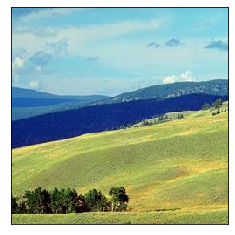

In [7]:
examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)
n = np.random.randint(low = 0, high = len(example_data)+1, size=1)[0]

print("N: {}".format(n))

x = preprocess_input(example_data)

model = ResNet50(weights='imagenet')
print (model.summary())
preds = model.predict(x)

examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)

print('Predicted:', decode_predictions(preds, top=3)[n])
print('Real:', CLASSES[np.argmax(example_targets[n])])

plt.imshow(example_data[n], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
label = CLASSES[np.argmax(example_targets[n])]
img   = example_data[n]

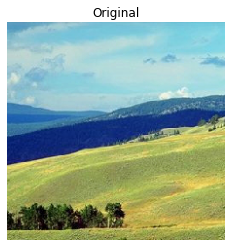

In [9]:
plt.title('Original')
plt.imshow(img)
plt.axis('off')
plt.show()

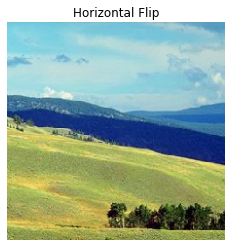

In [10]:
flippedh = tf.image.flip_left_right(img)

plt.title('Horizontal Flip')
plt.imshow(flippedh)
plt.axis('off')
plt.show()

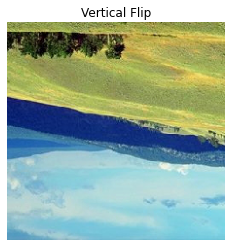

In [11]:
flippedv = tf.image.flip_up_down(img)

plt.title('Vertical Flip')
plt.imshow(flippedv)
plt.axis('off')
plt.show()

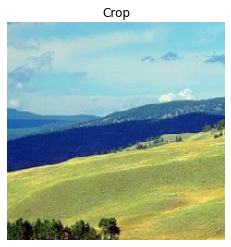

In [12]:
crop = tf.image.stateless_random_crop(
      img, size=[200, 200, 3], seed=(42, 0))


plt.title('Crop')
plt.imshow(crop)
plt.axis('off')
plt.show()

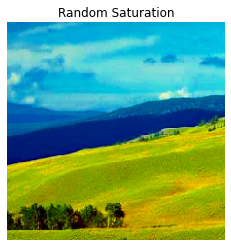

In [13]:
sat = tf.image.adjust_saturation(img, 3)
plt.title('Random Saturation')
plt.imshow(sat)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


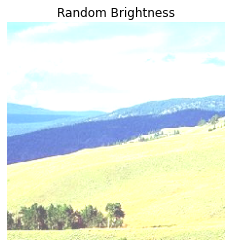

In [14]:
brr = tf.image.adjust_brightness(img, 0.4)
plt.title('Random Brightness')
plt.imshow(brr)
plt.axis('off')
plt.show()

# ResNet50 Finetuning

## Set a new model from an existing architecture

Now we are we are going to use ResNet50's skeleton and use those features to build our classifier. We will add the FC layers and perform the classification.

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [16]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

In [17]:
def buil_custom_resnet50(log=True, lr=1e-3, loss='categorical_crossentropy'):
    
    # ResNet Base Model
    base_model = ResNet50(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet', include_top=False)
    
    x = base_model.output
    
    # We Flatten with GlobalAveragePooling2D()
    x = GlobalAveragePooling2D()(x) # final feature vector

    # Perform classification
    predictions = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # We don't want to modify imagenet weights
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    
    #if log:
    #    print (model.summary())

    return model

# Define Custom Network

In [51]:
# either to use the originals or modifications from the paper
# Identity Mappings in Deep Residual Networks: https://arxiv.org/abs/1603.05027

USE_MOD = True

In [54]:
if USE_MOD:
    
    print ('Using modified blocks')
    def identity_block(x, filter):

        x_skip = x

        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)

        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)

        # residual
        x = tf.keras.layers.Add()([x, x_skip])     
        #x = tf.keras.layers.Activation('relu')(x)
        return x
else:
    
    print ('Using original blocks')
    def identity_block(x, filter):

        x_skip = x

        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)

        # residual
        x = tf.keras.layers.Add()([x, x_skip])     
        x = tf.keras.layers.Activation('relu')(x)
        return x

Using modified blocks


In [55]:
if USE_MOD:
    print ('Using modified blocks')
    def convolutional_block_mod(x, filter):
        x_skip = x

        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)

        # Processing Residue with conv(1,1)
        # if dimensions/shapes don't allow to add residuals
        x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
        # residual
        x = tf.keras.layers.Add()([x, x_skip])     
        #x = tf.keras.layers.Activation('relu')(x)
        return x
    
else:
    print ('Using original blocks')
    def convolutional_block(x, filter):
        # copy tensor to variable called x_skip
        x_skip = x

        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)

        # Processing Residue with conv(1,1)
        # if dimensions/shapes don't allow to add residuals
        x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
        # residual
        x = tf.keras.layers.Add()([x, x_skip])     
        x = tf.keras.layers.Activation('relu')(x)
        return x

Using modified blocks


In [63]:
def ResNet34(shape = (IMG_SIZE, IMG_SIZE, 3), classes = len(CLASSES)):
    

    x_input = tf.keras.layers.Input(shape)
    
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    
    # Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    # These numbers are from the official paper definition of ResNet34
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    
    #Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    
    print (x.shape)
    # Head classifier
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
    
    return model

In [64]:
tf.keras.backend.clear_session()

model = ResNet34()
model.summary()

(None, 8, 8, 512)
Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 115, 115, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 115, 115, 64) 256         conv2d[0][0]                     
_________________________________________________________________________

In [65]:
DATASETS = [
    (train_loader_1, test_loader_1),
    (train_loader_2, test_loader_2),
    (train_loader_3, test_loader_3),
    (train_loader_4, test_loader_4),
]

In [66]:
# Training on different datasets

for idx, dataset in enumerate(DATASETS):
    
    train_loader = dataset[0]
    test_loader  = dataset[1]
    
    idx +=1
    print ('Training on Dataset', idx, train_loader.samples, test_loader.samples )
    if idx == 1: print_summary=True
    else: print_summary=False
        
    ### LOGS AND TRACKING

    checkpoint = tf.keras.callbacks.ModelCheckpoint  (f'model_{idx}.h5', save_best_only=True, monitor='val_acc', mode='max', verbose=0)
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)
    earlystop  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

        
    model   = ResNet34()
    history = model.fit(train_loader ,steps_per_epoch=train_loader.samples // BATCH_SIZE, epochs=5, validation_data=test_loader, validation_steps=test_loader.samples // BATCH_SIZE)
    
    break
    

Training on Dataset 1 400 2288
(None, 8, 8, 512)
Epoch 1/5
6/6 [==============================] - 10s 1s/step - loss: 27.9639 - accuracy: 0.1310 - val_loss: 126985848.0000 - val_accuracy: 0.1201
Epoch 2/5
6/6 [==============================] - 5s 972ms/step - loss: 19.9827 - accuracy: 0.1696 - val_loss: 25492592.0000 - val_accuracy: 0.1219
Epoch 3/5
6/6 [==============================] - 5s 963ms/step - loss: 8.9864 - accuracy: 0.1815 - val_loss: 14236685.0000 - val_accuracy: 0.1210
Epoch 4/5
6/6 [==============================] - 5s 983ms/step - loss: 5.3992 - accuracy: 0.1696 - val_loss: 2481313.7500 - val_accuracy: 0.1411
Epoch 5/5
6/6 [==============================] - 5s 970ms/step - loss: 4.1858 - accuracy: 0.2292 - val_loss: 65712.2656 - val_accuracy: 0.0924


In [ ]:
plot_loss_accuracy(history_1, 'ResNet50 + GAP + Dense: Dataset 1')
plot_loss_accuracy(history_2,  'ResNet50 + GAP + Dense: Dataset 2')
plot_loss_accuracy(history_3,  'ResNet50 + GAP + Dense: Dataset 3')
plot_loss_accuracy(history_4,  'ResNet50 + GAP + Dense: Dataset 4')

We observe how ResNet50 + GlobalAveragePooling + 1024 FC outperforms our best MLP model that was around 60% accuracy by a big margin (100% train and 90-93% for test). CNNs show their power when it comes to images.